In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("Loan_default..csv")
print("Shape:", df.shape)
df.head()

Shape: (148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
TARGET = "Status"

# Remove ID column
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

df = df.replace([np.inf, -np.inf], np.nan)
df[TARGET] = df[TARGET].astype(int)

print(df[TARGET].value_counts())


Status
0    112031
1     36639
Name: count, dtype: int64


In [6]:
LEAK_COLS = [
    "submission_of_application",
    "Security_Type",
    "dtir1",
]

df = df.drop(columns=[c for c in LEAK_COLS if c in df.columns])
print("Remaining columns:", len(df.columns))



Remaining columns: 30


In [7]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (118936, 29) Test: (29734, 29)


In [8]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_process = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_process = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", numeric_process, num_cols),
    ("cat", categorical_process, cat_cols)
])

In [18]:
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=6, min_samples_leaf=40,
        min_samples_split=80, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=7,
        min_samples_leaf=30, min_samples_split=80,
        class_weight="balanced", random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=250, max_depth=3,
        learning_rate=0.05, subsample=0.7,
        colsample_bytree=0.6, min_child_weight=10,
        gamma=2.0, reg_alpha=1.0, reg_lambda=5.0,
        eval_metric='auc', random_state=42, n_jobs=-1
    )
}

In [19]:
def get_roc_auc(pipe, X_test, y_test):
    try:
        y_prob = pipe.predict_proba(X_test)[:, 1]
    except:
        y_prob = pipe.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    return fpr, tpr, auc(fpr, tpr)

In [20]:
def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"\n🔹 {name} Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()




================ TRAINING Logistic Regression ================

🔹 Logistic Regression Accuracy: 83.54%
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22406
           1       0.66      0.67      0.67      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.78      0.78     29734
weighted avg       0.84      0.84      0.84     29734



<Figure size 1000x700 with 0 Axes>

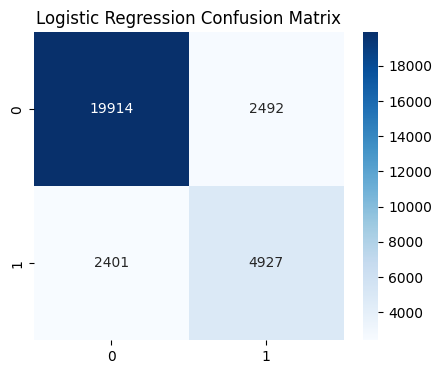


================ TRAINING Decision Tree ================

🔹 Decision Tree Accuracy: 99.97%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



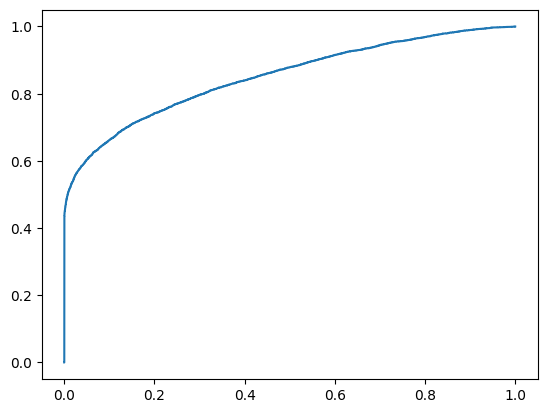

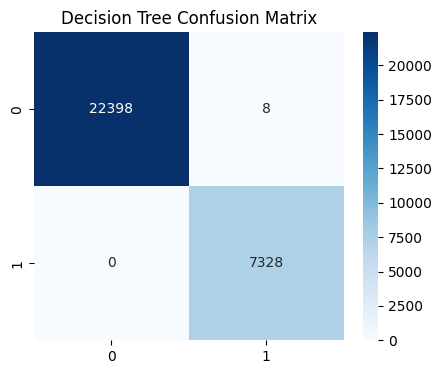


================ TRAINING Random Forest ================

🔹 Random Forest Accuracy: 99.98%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



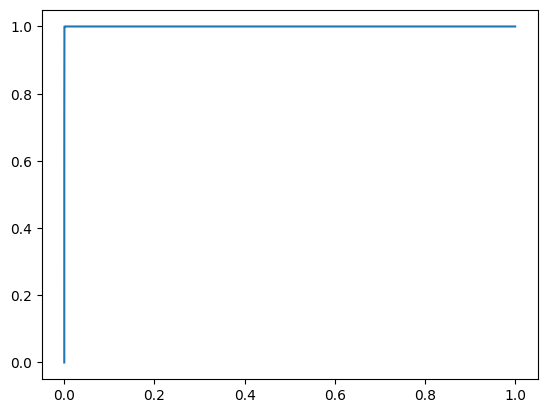

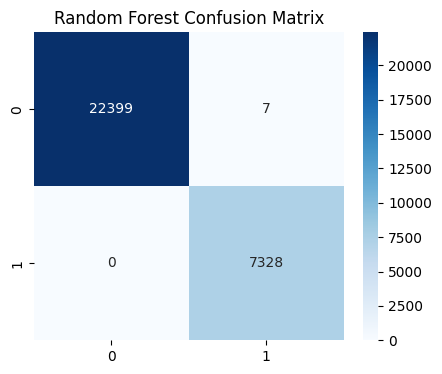


================ TRAINING Naive Bayes ================

🔹 Naive Bayes Accuracy: 87.50%
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     22406
           1       1.00      0.49      0.66      7328

    accuracy                           0.88     29734
   macro avg       0.93      0.75      0.79     29734
weighted avg       0.89      0.88      0.86     29734



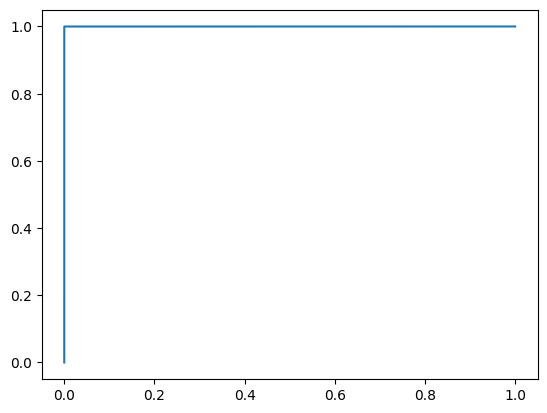

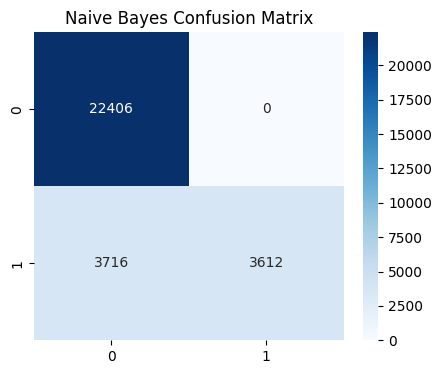


================ TRAINING Linear SVM ================

🔹 Linear SVM Accuracy: 83.77%
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     22406
           1       0.68      0.65      0.66      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.77      0.78     29734
weighted avg       0.84      0.84      0.84     29734



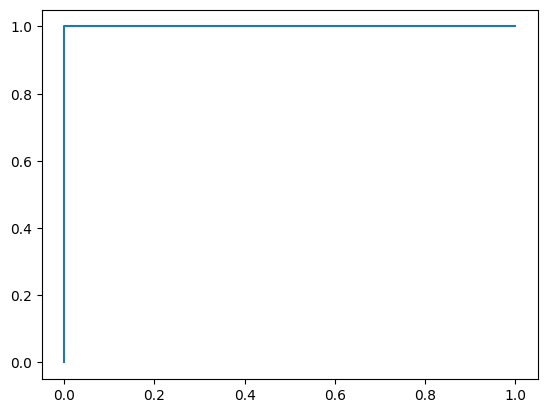

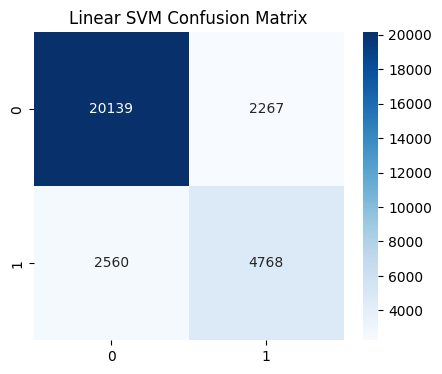


================ TRAINING XGBoost ================

🔹 XGBoost Accuracy: 99.99%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



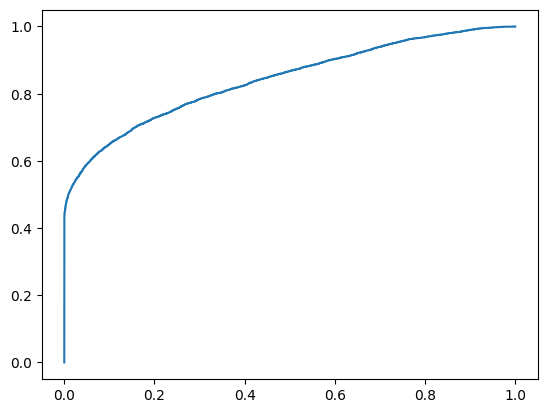

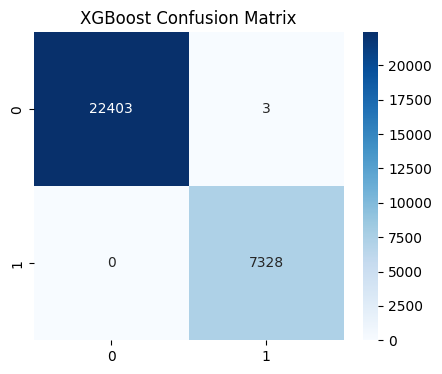

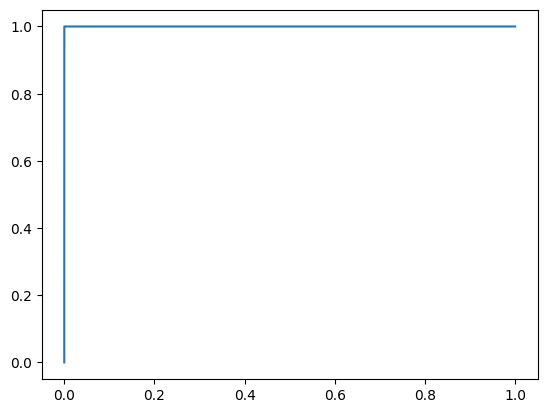

In [23]:
combined_results = []

plt.figure(figsize=(10,7))

for name, clf in models.items():

    print(f"\n================ TRAINING {name} ================")

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Record metrics
    combined_results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred, zero_division=0),
        "Test Precision": precision_score(y_test, y_test_pred, zero_division=0),
        "Train Recall": recall_score(y_train, y_train_pred, zero_division=0),
        "Test Recall": recall_score(y_test, y_test_pred, zero_division=0),
        "Train F1": f1_score(y_train, y_train_pred, zero_division=0),
        "Test F1": f1_score(y_test, y_test_pred, zero_division=0),
    })

    # Confusion matrix + report
    evaluate_model(pipe, name, X_test, y_test)

    # ROC curve
    fpr, tpr, roc_auc = get_roc_auc(pipe, X_test, y_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8608\1889548038.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


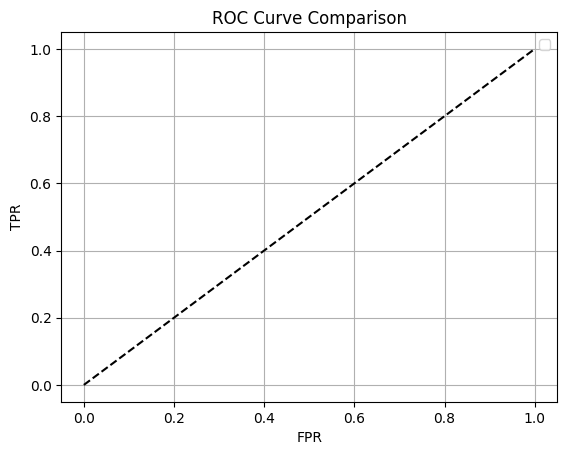

In [25]:
# ROC final plot
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.grid()
plt.show()

In [26]:
results_df = pd.DataFrame(combined_results)
results_df["Train Accuracy %"] = (results_df["Train Accuracy"]*100).round(2)
results_df["Test Accuracy %"] = (results_df["Test Accuracy"]*100).round(2)

results_df


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train Accuracy %,Test Accuracy %
0,Logistic Regression,0.830985,0.835441,0.656653,0.664106,0.658490,0.672353,0.657570,0.668204,83.10,83.54
1,Decision Tree,0.999924,0.999731,0.999693,0.998909,1.000000,1.000000,0.999846,0.999454,99.99,99.97
2,Random Forest,0.999790,0.999765,0.999148,0.999046,1.000000,1.000000,0.999574,0.999523,99.98,99.98
3,Naive Bayes,0.869913,0.875025,1.000000,1.000000,0.472144,0.492904,0.641437,0.660329,86.99,87.50
4,Linear SVM,0.832700,0.837661,0.668916,0.677754,0.635870,0.650655,0.651975,0.663928,83.27,83.77
5,XGBoost,0.999958,0.999899,0.999829,0.999591,1.000000,1.000000,0.999915,0.999795,100.00,99.99


In [27]:
from sklearn.metrics import confusion_matrix

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)            # Recall
    specificity = tn / (tn + fp)            # True Negative Rate
    precision = tp / (tp + fp) if (tp+fp) > 0 else 0
    f1 = (2 * precision * sensitivity) / (precision + sensitivity) if (precision+sensitivity) > 0 else 0

    return accuracy, sensitivity, specificity, precision, f1

In [28]:
final_results = []

for name, clf in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)

    # Train & Test predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred  = pipe.predict(X_test)

    # Train metrics
    t_acc, t_sens, t_spec, t_prec, t_f1 = compute_metrics(y_train, y_train_pred)

    # Test metrics
    v_acc, v_sens, v_spec, v_prec, v_f1 = compute_metrics(y_test, y_test_pred)

    final_results.append({
        "Model": name,

        "Train Accuracy": t_acc,
        "Train Sensitivity": t_sens,
        "Train Specificity": t_spec,
        "Train Precision": t_prec,
        "Train F1": t_f1,

        "Test Accuracy": v_acc,
        "Test Sensitivity": v_sens,
        "Test Specificity": v_spec,
        "Test Precision": v_prec,
        "Test F1": v_f1,
    })

In [29]:
final_df = pd.DataFrame(final_results)

In [30]:
for col in final_df.columns:
    if col != "Model":
        final_df[col] = (final_df[col] * 100).round(2)

final_df

,Model,Train Accuracy,Train Sensitivity,Train Specificity,Train Precision,Train F1,Test Accuracy,Test Sensitivity,Test Specificity,Test Precision,Test F1
0,Logistic Regression,83.10,65.85,88.74,65.67,65.76,83.54,67.24,88.88,66.41,66.82
1,Decision Tree,99.99,100.00,99.99,99.97,99.98,99.97,100.00,99.96,99.89,99.95
2,Random Forest,99.98,100.00,99.97,99.91,99.96,99.98,100.00,99.97,99.90,99.95
3,Naive Bayes,86.99,47.21,100.00,100.00,64.14,87.50,49.29,100.00,100.00,66.03
4,Linear SVM,83.27,63.59,89.71,66.89,65.20,83.77,65.07,89.88,67.78,66.39
5,XGBoost,100.00,100.00,99.99,99.98,99.99,99.99,100.00,99.99,99.96,99.98


In [31]:
results_df.to_csv('model_performance_full_evaluation.csv', index=True)
print("Results saved to model_performance_full_evaluation.csv")

Results saved to model_performance_full_evaluation.csv


In [34]:
final_df.to_csv('model_performance_full_evaluation.csv', index=True)
print("Results saved to model_performance_full_evaluation.csv")

Results saved to model_performance_full_evaluation.csv
